In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn
import torch.distributions as dists
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions.distribution import Distribution
from np_utils import simple_data, curved_data
from torch_utils import rotation_test, get_limits, TrainUtil
from tension_net import TensionNet, TensionNet1, TensionNet2
from tension_quantify import GaussianKDE, BayesFactorKDE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
x = np.random.randn(10000) / 2 + 5
X = torch.tensor(x).float().to(device)
X = X.unsqueeze(1)
y = np.linspace(2, 8, 1000)
Y = torch.tensor(y).float().to(device)

kde = GaussianKDE(X, device)
start = time.time()
probs = kde.prob(Y)
print("probs ", time.time() - start)
start = time.time()
log_probs = kde.log_prob(Y)
print("log_probs ", time.time() - start)
cdf_probs = kde.cdf(Y)

kde_scipy = gaussian_kde(x)
probs_scipy = kde_scipy(y)
log_probs_scipy = kde_scipy.logpdf(y)
cdf_probs_scipy = np.cumsum(probs_scipy)
cdf_probs_scipy /= np.max(cdf_probs_scipy)

probs  0.0028803348541259766
log_probs  0.012848138809204102


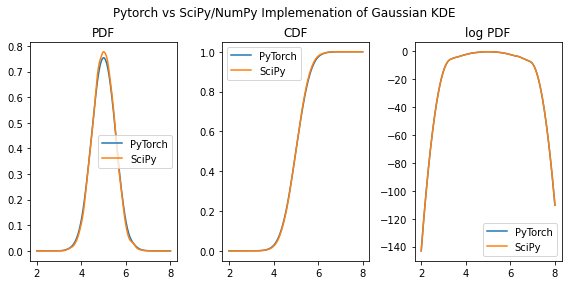

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
fig.suptitle("Pytorch vs SciPy/NumPy Implemenation of Gaussian KDE")

axs[0].plot(y, probs.cpu(), label="PyTorch")
axs[0].plot(y, probs_scipy, label="SciPy")
axs[0].set_title("PDF")
axs[0].legend()

axs[1].plot(y, cdf_probs.cpu(), label="PyTorch")
axs[1].plot(y, cdf_probs_scipy, label="SciPy")
axs[1].set_title("CDF")
axs[1].legend()

axs[2].plot(y, log_probs.cpu(), label="PyTorch")
axs[2].plot(y, log_probs_scipy, label="SciPy")
axs[2].set_title("log PDF")
axs[2].legend()

fig.tight_layout(rect=[0, 0, 1, 0.95])

In [ ]:
X0, X1, X_prior = simple_data(dims=2, distance=0.5, fixed=True)
X0_tnsr = torch.tensor(X0).float().to(device)
X1_tnsr = torch.tensor(X1).float().to(device)
X_prior_tnsr = torch.tensor(X_prior).float().to(device)

True 3.9338185787200928
False 8.468122482299805


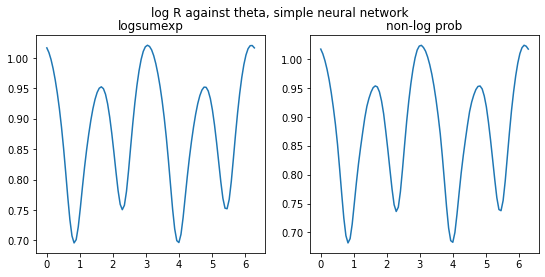

In [ ]:
import time

tension_R = TensionNet(2).to(device)
conds = [True, False]
thetas = []
losses = []

for cond in conds:
    start = time.time()
    criterion = BayesFactorKDE(device, n_points=1000, logsumexp=cond).to(device)
    theta, loss, _ = rotation_test(tension_R, criterion, device, X0, X1, X_prior)
    thetas.append(theta)
    losses.append(loss)
    print(cond, time.time() - start)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle("log R against theta, simple neural network")
for i in range(2):
    axs[i].plot(thetas[i], losses[i])
    if i == 0:
        axs[0].set_title("logsumexp")
    else:
        axs[1].set_title("non-log prob")

In [ ]:
train_utils = []
distances = [0.5, 1, 2, 5, 10]
for dist in distances:
    X0, X1, X_prior = simple_data(dims=2, distance=dist, fixed=True)
    tension_R = TensionNet1(2)

    criterion = BayesFactorKDE(device, n_points=1000, logsumexp=True)
    optimizer = optim.SGD(tension_R.parameters(), lr=0.0005)
    train_util_R = TrainUtil(tension_R, optimizer, criterion, device)
    losses_R = train_util_R.train(X0, X1, X_prior, n_iter=200, no_prior_iter=20)
    train_utils.append(train_util_R)

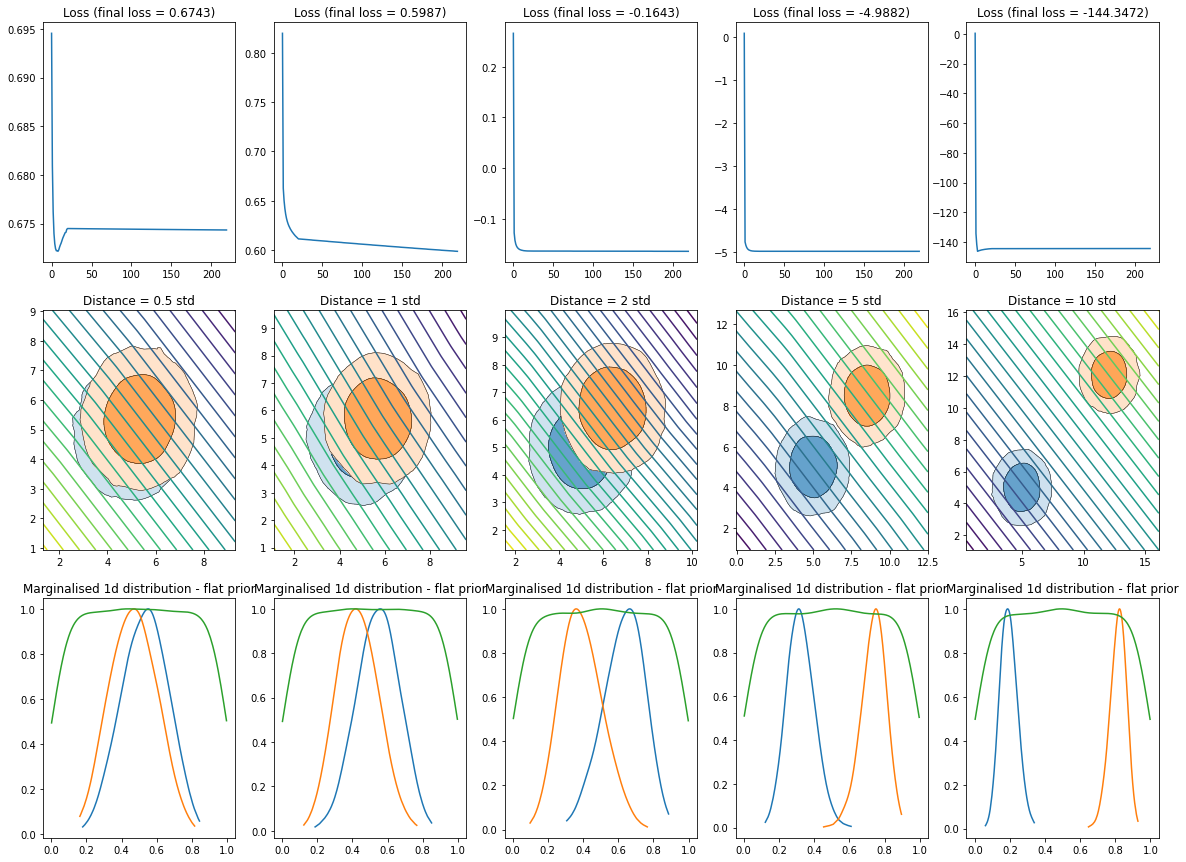

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(20, 15))

for i, util in enumerate(train_utils):
    util.plot_loss(axs[0, i])
    util.visualise_coordinate(axs[1, i])
    util.plot_marginalised_dists(axs[2, i], flat_prior=True)
    axs[1, i].set_title(f"Distance = {distances[i]} std")

In [ ]:
X0, X1, X_prior = simple_data(dims=6, distance=5)

In [ ]:
tension_R = TensionNet1(6, hidden_size=64)
criterion = BayesFactorKDE(device, n_points=1000, logsumexp=True)
optimizer = optim.Adam(tension_R.parameters(), lr=0.0005)

train_util_R = TrainUtil(tension_R, optimizer, criterion, device,
                         animation=False)
losses_R = train_util_R.train(X0, X1, X_prior, n_iter=500)

In [ ]:
tension_R_np = TensionNet1(6, hidden_size=64)
criterion = BayesFactorKDE(device, n_points=1000, logsumexp=True, 
                           prior_division=False)
optimizer = optim.Adam(tension_R_np.parameters(), lr=0.05)

train_util_R_np = TrainUtil(tension_R_np, optimizer, criterion, device,
                         animation=False)
losses_R_np = train_util_R_np.train(X0, X1, X_prior, n_iter=500)

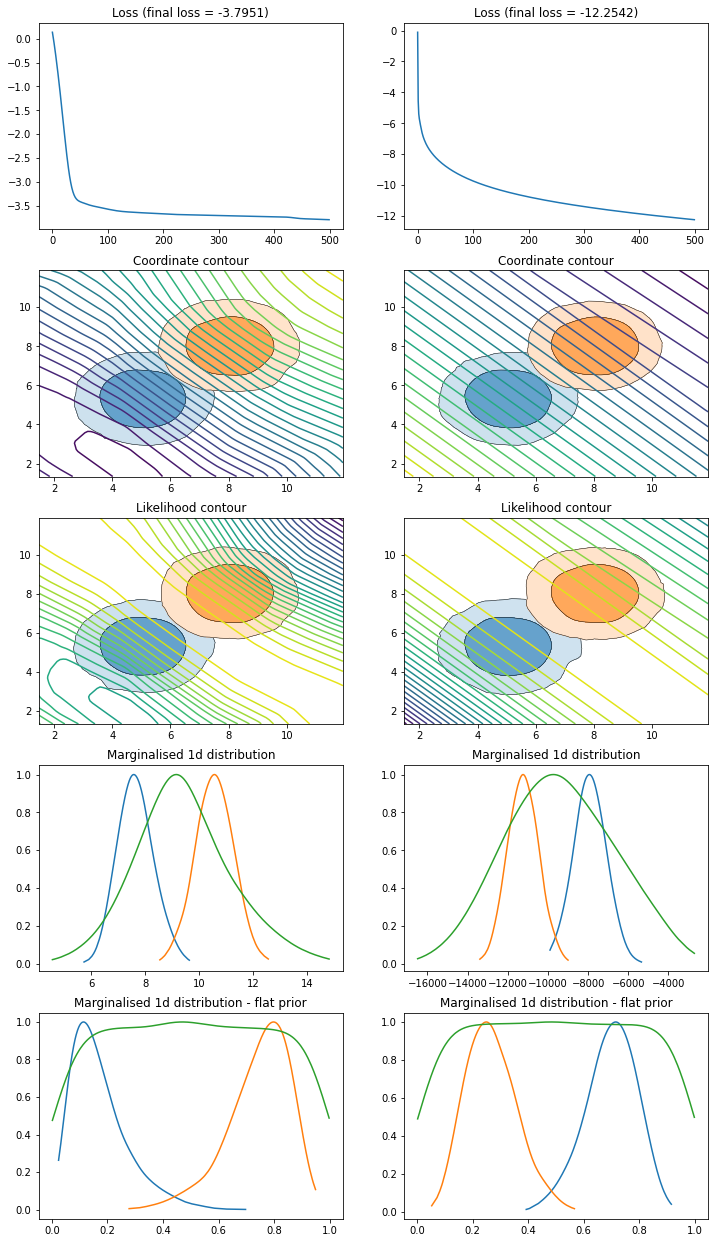

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 22))

train_util_R.plot_loss(axs[0, 0])
train_util_R.visualise_coordinate(axs[1, 0], idxs=(0, 1))
train_util_R.visualise_tension(axs[2, 0], idxs=(0, 1))
train_util_R.plot_marginalised_dists(axs[3, 0])
train_util_R.plot_marginalised_dists(axs[4, 0], flat_prior=True)

train_util_R_np.plot_loss(axs[0, 1])
train_util_R_np.visualise_coordinate(axs[1, 1], idxs=(0, 1))
train_util_R_np.visualise_tension(axs[2, 1], idxs=(0, 1))
train_util_R_np.plot_marginalised_dists(axs[3, 1])
train_util_R_np.plot_marginalised_dists(axs[4, 1], flat_prior=True)

/content/drive/My Drive/project/torch_utils.py:252: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


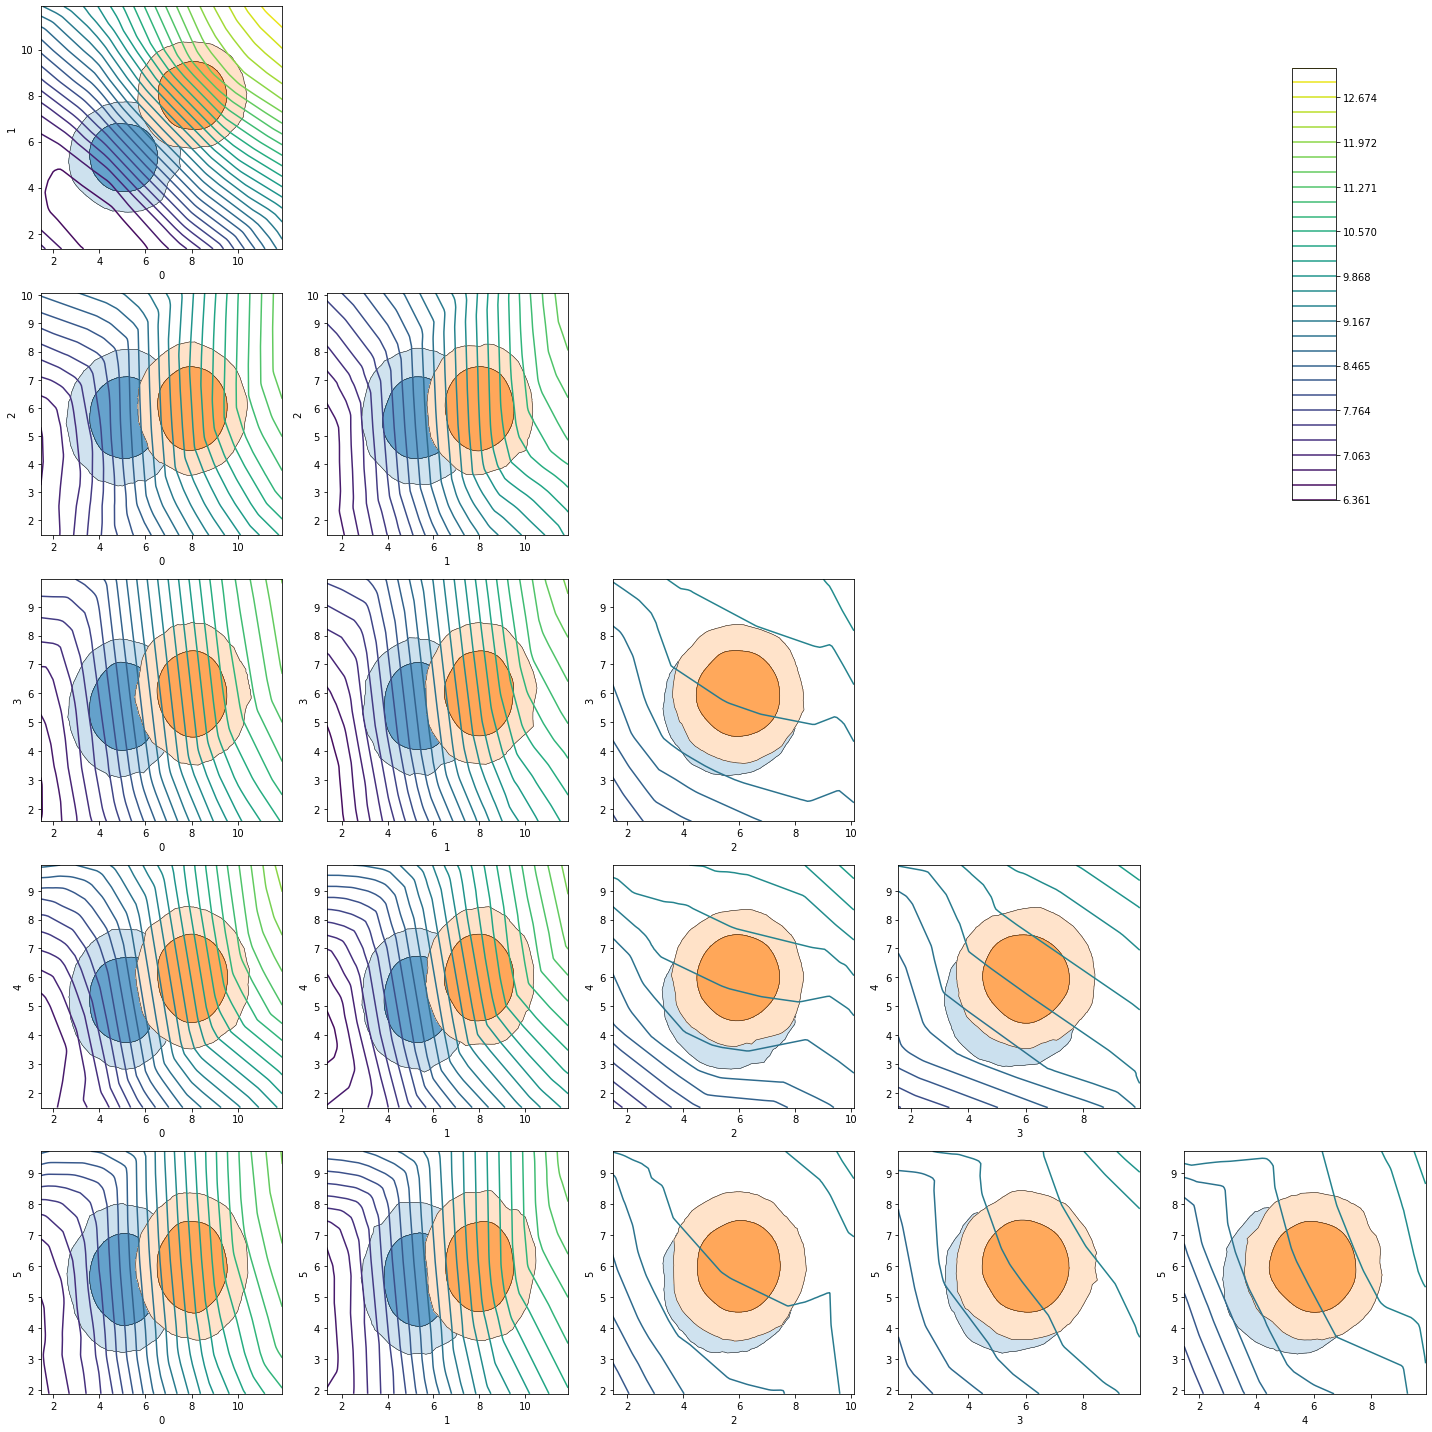

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
train_util_R.visualise_coordinates_all(fig, axs)

In [ ]:
X0_c, X1_c, X_prior_c = curved_data(dims=6)

In [ ]:
tension_R_c = TensionNet2(6, hidden_size=(64, 32))
criterion = BayesFactorKDE(device, n_points=1000, logsumexp=True)
optimizer = optim.Adam(tension_R_c.parameters(), lr=0.0005)

train_util_R_c = TrainUtil(tension_R_c, optimizer, criterion, device,
                         animation=False)
losses_R_c = train_util_R_c.train(X0_c, X1_c, X_prior_c, n_iter=500)

In [ ]:
tension_R_np_c = TensionNet2(6, hidden_size=(64, 32))
criterion = BayesFactorKDE(device, n_points=1000, logsumexp=True,
                           prior_division=False)
optimizer = optim.Adam(tension_R_np_c.parameters(), lr=0.0005)

train_util_R_np_c = TrainUtil(tension_R_np_c, optimizer, criterion, device,
                         animation=False)
losses_R_np_c = train_util_R_np_c.train(X0_c, X1_c, X_prior_c, n_iter=1000)

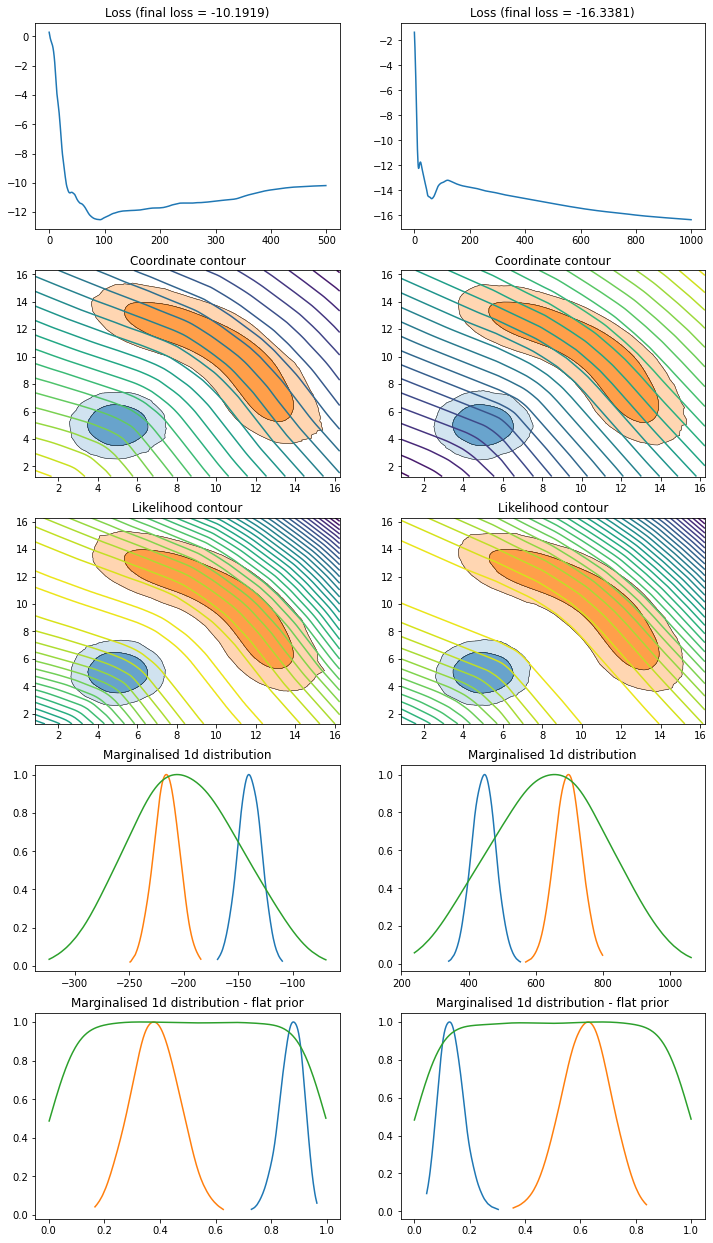

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 22))

train_util_R_c.plot_loss(axs[0, 0])
train_util_R_c.visualise_coordinate(axs[1, 0], idxs=(0, 1))
train_util_R_c.visualise_tension(axs[2, 0], idxs=(0, 1))
train_util_R_c.plot_marginalised_dists(axs[3, 0])
train_util_R_c.plot_marginalised_dists(axs[4, 0], flat_prior=True)

train_util_R_np_c.plot_loss(axs[0, 1])
train_util_R_np_c.visualise_coordinate(axs[1, 1], idxs=(0, 1))
train_util_R_np_c.visualise_tension(axs[2, 1], idxs=(0, 1))
train_util_R_np_c.plot_marginalised_dists(axs[3, 1])
train_util_R_np_c.plot_marginalised_dists(axs[4, 1], flat_prior=True)

/content/drive/My Drive/project/torch_utils.py:252: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


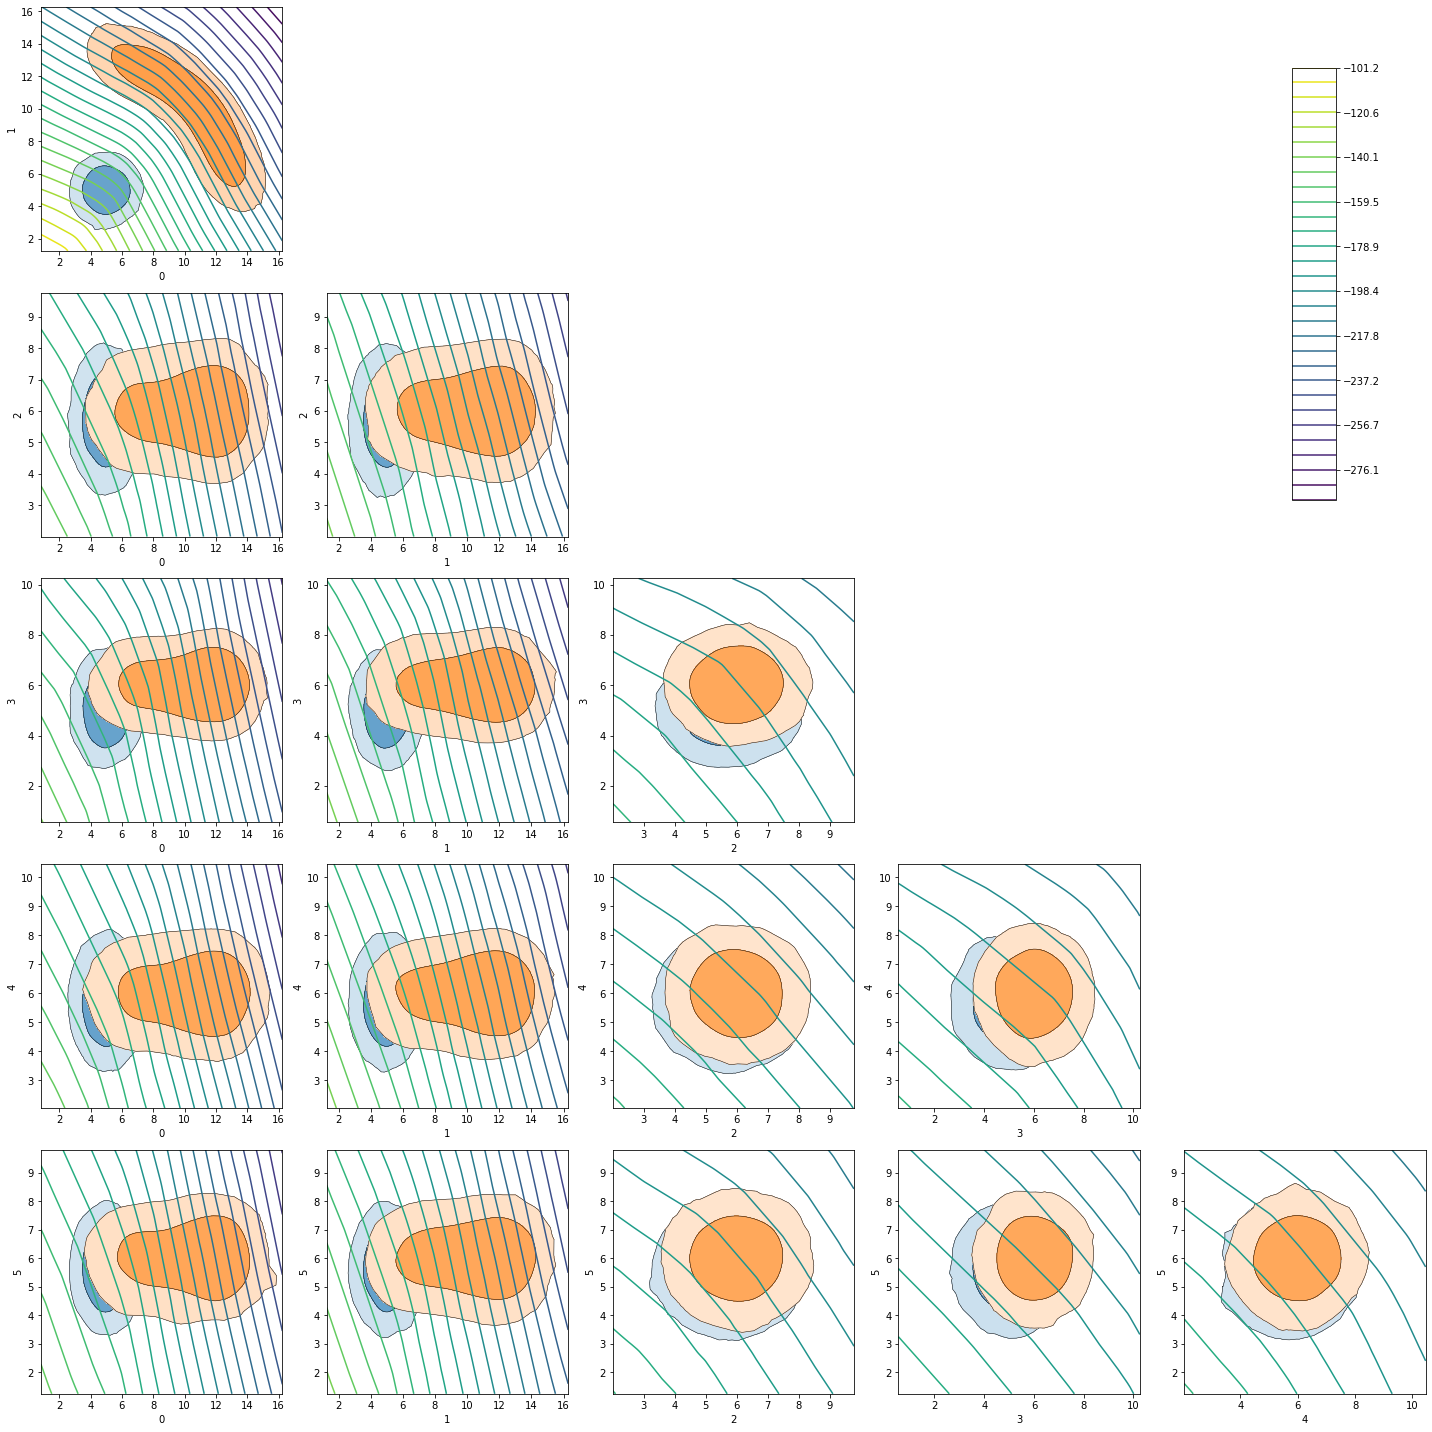

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
train_util_R_c.visualise_coordinates_all(fig, axs)